# 1.Setup

## Import Libs

In [1]:
###Import libs
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt



In [2]:
###Use GPU
print("Num GPUs Available: ", torch.cuda.device_count())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Num GPUs Available:  1
Using device: cuda


In [3]:
###Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

## Initialise solver

### Generic functions

In [4]:
###Define laplacian operator
def laplacian(field, dx):
        # Assume periodic boundaries
        lap = (torch.roll(field, 1, 0) + torch.roll(field, -1, 0) +
               torch.roll(field, 1, 1) + torch.roll(field, -1, 1) - 4 * field) / (dx ** 2)
        return lap

In [5]:
###Define BDF1 time integrator with Newton-Krylov linear solves 
def bdf1_newton_krylov(X0, dt, Tmax, rhs_func, jvp_func=None, tol=1e-3, max_iter=10, gmres_max_iter=200, save_interval=1):
    steps = int(Tmax / dt)
    X = X0.clone()
    trajectory = []

    #Loop through time steps
    for step in range(steps):

        #Save trajectory at interval
        if step % save_interval == 0:
            trajectory.append(X.clone().cpu())

        #Print progress at interval
        print_interval = 1000
        if print_interval and (step % print_interval) == 0:
            print(f"Simulation progress: step {step+1}/{steps}")

        # Initial guess for Newton's method
        X_n = X.clone()
        f_n = rhs_func(X_n)
        X_guess = X_n + dt * f_n

        # Prepare Jacobian Vector Product function
        jvp_func = make_autograd_jvp(rhs_func)

        # Newton iterations
        for newton_iter in range(max_iter):
            #Compute residual
            f_val = rhs_func(X_guess)
            G = X_guess - dt * f_val - X_n

            #Check convergence
            if torch.norm(G) < tol:
                if step % print_interval == 0:  # print Newton convergence info at same interval
                    print(f"Newton converged in {newton_iter+1} iterations at step {step+1}")
                break

            #Solve for Newton update using GMRES
            A = lambda v: jvp_func(v, X_guess, dt)
            b_gmres = -G
            P = lambda v: v
            w = gmres_torch(A, b_gmres, P=P, tol=tol, max_iter=gmres_max_iter)
            X_guess += w
        else:
            print(f"Newton did not converge at step {step+1} after {max_iter} iterations")
            
        # Update solution
        X = X_guess.clone()


    return trajectory

In [6]:
###Generalized Minimal Residual
def gmres_torch(A, b, P=None, tol=1e-6, max_iter=200):
    #Initialise variables
    if P is None:
        P = lambda v: v
    n = b.shape[0]
    Q = torch.zeros((n, max_iter+1), dtype=b.dtype, device=b.device)
    H = torch.zeros((max_iter+1, max_iter), dtype=b.dtype, device=b.device)

    #GMRES iterations
    x = torch.zeros_like(b)
    r0 = b - A(x)
    r = P(r0)
    beta = torch.norm(r)
    if beta == 0:
        return x
    Q[:, 0] = r / beta

    #Arnoldi process
    for k in range(max_iter):
        q = P(A(Q[:, k]))
        for i in range(k+1):
            H[i, k] = torch.dot(Q[:, i], q)
            q = q - H[i, k] * Q[:, i]
        h = torch.norm(q)
        H[k+1, k] = h
        if h < 1e-12:
            break
        Q[:, k+1] = q / h

        e1 = torch.zeros(k+2, dtype=b.dtype, device=b.device)
        e1[0] = beta
        H_small = H[:k+2, :k+1]
        y, *_ = torch.linalg.lstsq(H_small, e1)
        x = Q[:, :k+1] @ y

        res_norm = torch.norm(P(b - A(x)))
        if res_norm < tol:
            break
    return x

In [7]:

###Autograd JVP factory and wrappers
def make_autograd_jvp(rhs_func):
    def jvp(v, X, dt):
        X_req = X.detach().requires_grad_(True)
        _, Jv = torch.autograd.functional.jvp(rhs_func, (X_req,), (v,), create_graph=False)
        return v - dt * Jv
    return jvp



### Target specific functions

### Full RNGRN system specific functions

In [ ]:
###Define RHS target
def rhs_target(X):
    n = n_cells
    n_nodes = n * n
    A = X[0:n_nodes].view(n, n)
    B = X[n_nodes:2 * n_nodes].view(n, n)
    E = X[2 * n_nodes:].view(n, n)

    lap_A = laplacian(A, dx)
    lap_B = laplacian(B, dx)

    D_local = D_ss(B)
    C_local = C_ss(B)
    F_local = F_ss(B)

    dA = 1.0 + p["Va"] * H_rep(D_local, p["Kda"], p["nda"]) - A + lap_A

    drive_B = p["Vb"] * H_act(A, p["Kub"], p["nub"]) * H_rep(E, p["Keb"], p["neb"])
    dB = p["mu_LVA"] * (1.0 + drive_B - B) + p["Dr"] * lap_B

    drive_E = (
        p["Ve"]
        * H_rep(C_local, p["Kce"], p["nce"])
        * H_rep(F_local, p["Kfe"], p["nfe"])
        * H_auto(E, p["Kee"], p["nee"])
    )
    dE = p["mu_LVA"] * (1.0 + drive_E - E)

    diffs = [dA, dB, dE]
    return torch.cat([d.flatten() for d in diffs])


In [9]:
###Define RHS perceptron
def rhs_perceptron(X):
    n = n_cells
    n_nodes = n * n
    nx = N * n_nodes  
    nG_per_type = N * N * n_nodes  
    nG_total = 2 * nG_per_type
    
    # Unpack X
    x = X[:nx].view(N, n_nodes)  
    G_A = X[nx:nx + nG_per_type].view(N, N, n_nodes) 
    G_R = X[nx + nG_per_type:].view(N, N, n_nodes) 
    
    # Compute G_free for each i
    G_free = 1.0 - G_A.sum(dim=1) - G_R.sum(dim=1)  
    
    # x dynamics with diffusion + reaction
    xdot = torch.zeros_like(x)
    for i in range(N):
        lap_x = D[i] * laplacian(x[i].view(n, n), dx)
        prod = beta[i] + (alpha[i].unsqueeze(1) * G_A[i]).sum(dim=0) - delta[i] * x[i]
        xdot[i] = lap_x.flatten() + prod
    
    # G dynamics using trimolecular binding
    Gdot_A = torch.zeros_like(G_A)
    Gdot_R = torch.zeros_like(G_R)
    for i in range(N):
        for j in range(N):
            Gdot_A[i, j] = (kA_plus[i, j] * x[j]**2 * G_free[i] - kA_minus[i, j] * G_A[i, j]) / mu
            Gdot_R[i, j] = (kR_plus[i, j] * x[j]**2 * G_free[i] - kR_minus[i, j] * G_R[i, j]) / mu
    
    return torch.cat([xdot.flatten(), Gdot_A.flatten(), Gdot_R.flatten()])


## Set target system

In [10]:
###Parameters of the reduced 3-node reaction–diffusion model 
p = {
    "Dr": torch.tensor(0.15, dtype=torch.float32, device=device),
    "mu_LVA": torch.tensor(3.57, dtype=torch.float32, device=device),

    # production strengths
    "Va": torch.tensor(21.67, dtype=torch.float32, device=device),
    "Vb": torch.tensor(321.54, dtype=torch.float32, device=device),
    "Vc": torch.tensor(16.88, dtype=torch.float32, device=device),
    "Vd": torch.tensor(5.29, dtype=torch.float32, device=device),
    "Ve": torch.tensor(8.60, dtype=torch.float32, device=device),
    "Vf": torch.tensor(3.57, dtype=torch.float32, device=device),

    # thresholds (K*)
    "Kub": torch.tensor(43.93, dtype=torch.float32, device=device),
    "Kvd": torch.tensor(26.33, dtype=torch.float32, device=device),
    "Kda": torch.tensor(0.73, dtype=torch.float32, device=device),
    "Kce": torch.tensor(2.34, dtype=torch.float32, device=device),
    "Kfe": torch.tensor(1.41, dtype=torch.float32, device=device),
    "Keb": torch.tensor(1.53, dtype=torch.float32, device=device),
    "Kee": torch.tensor(0.001, dtype=torch.float32, device=device),

    # Hill coefficients
    "nub": torch.tensor(1.0, dtype=torch.float32, device=device),
    "nvd": torch.tensor(2.0, dtype=torch.float32, device=device),
    "nda": torch.tensor(2.0, dtype=torch.float32, device=device),
    "nce": torch.tensor(3.0, dtype=torch.float32, device=device),
    "neb": torch.tensor(4.0, dtype=torch.float32, device=device),
    "nee": torch.tensor(4.0, dtype=torch.float32, device=device),
    "nfe": torch.tensor(8.0, dtype=torch.float32, device=device),
}


In [11]:
###Helper nonlinearities and quasi-steady closures
#Hill repression

def H_rep(X, K, n):
    return 1.0 / (1.0 + (X / K) ** n)

#Hill activation

def H_act(X, K, n, eps=1e-12):
    return 1.0 / (1.0 + (K / (X + eps)) ** n)

#Autoactivation used in the E* equation

def H_auto(E, Kee, nee, eps=1e-12):
    return 1.0 / (1.0 + (Kee / (E + eps)) ** nee)

#Quasi-steady-state closures eliminating C*, D*, F*

def D_ss(B):
    return 1.0 + p["Vd"] * H_act(B, p["Kvd"], p["nvd"])

def C_ss(B):
    D_local = D_ss(B)
    return 1.0 + p["Vc"] * H_rep(D_local, p["Kda"], p["nda"])

def F_ss(B):
    return 1.0 + p["Vf"] * H_act(B, p["Kvd"], p["nvd"])


# 2.Quasi-Static Approximation

## Setup

In [12]:
###Set domain params
n_cells = 10
L = torch.tensor(5.0, dtype=torch.float32, device=device)
dx = float(L) / float(n_cells)


In [13]:
###Set target simulation params
dt = torch.tensor(0.01, dtype=torch.float32, device=device)
Tmax = torch.tensor(500.0, dtype=torch.float32, device=device)
steps = int(Tmax / dt)

In [14]:
###Set intitial conditions
n_species = 3
init_fields = []
for _ in range(n_species):
    field = torch.clamp(1.0 + 0.1 * torch.randn(n_cells, n_cells, dtype=torch.float32, device=device), min=0.001)
    init_fields.append(field)

X0 = torch.cat([f.flatten() for f in init_fields]).to(device)


## Generate training data

In [15]:
###Simulate target system 
trajectory = bdf1_newton_krylov(X0, dt, Tmax, rhs_target, jvp_func=None, save_interval=1)
print(f"Simulation completed with {len(trajectory)} time steps")

Simulation progress: step 1/50000
Newton converged in 2 iterations at step 1
Simulation progress: step 1001/50000
Newton converged in 1 iterations at step 1001
Simulation progress: step 2001/50000
Newton converged in 1 iterations at step 2001
Simulation progress: step 3001/50000
Newton converged in 1 iterations at step 3001
Simulation progress: step 4001/50000
Newton converged in 1 iterations at step 4001
Simulation progress: step 5001/50000
Newton converged in 1 iterations at step 5001
Simulation progress: step 6001/50000
Newton converged in 1 iterations at step 6001
Simulation progress: step 7001/50000
Newton converged in 1 iterations at step 7001
Simulation progress: step 8001/50000
Newton converged in 1 iterations at step 8001
Simulation progress: step 9001/50000
Newton converged in 1 iterations at step 9001
Simulation progress: step 10001/50000
Newton converged in 1 iterations at step 10001
Simulation progress: step 11001/50000
Newton converged in 1 iterations at step 11001
Simula

In [16]:
###Generate training data
#Prepare storage
field_trajectory = []
lap_trajectory = []
dx_dt_trajectory = []

n_nodes = n_cells * n_cells
n_species = 3
subsample_factor = 1 

#Loop through each time step 
for i in range(0, len(trajectory), subsample_factor):
    X = trajectory[i].to(device) 
    fields = [X[j * n_nodes:(j + 1) * n_nodes].view(n_cells, n_cells) for j in range(n_species)]
    laps = [laplacian(f, dx) for f in fields]

    dX = rhs_target(X)
    d_fields = [dX[j * n_nodes:(j + 1) * n_nodes].view(n_cells, n_cells) for j in range(n_species)]

    field_trajectory.append(torch.stack([f.clone() for f in fields]))
    lap_trajectory.append(torch.stack(laps))
    dx_dt_trajectory.append(torch.stack(d_fields))

#Generate feature and target tensors
fields_stacked = torch.stack(field_trajectory)  
laps_stacked = torch.stack(lap_trajectory)      
feature_tensor = torch.cat([fields_stacked, laps_stacked], dim=1)  

dx_dt_stacked = torch.stack(dx_dt_trajectory)  
target_tensor = dx_dt_stacked

print(f"Feature tensor shape: {feature_tensor.shape}")
print(f"Target tensor shape: {target_tensor.shape}")


Feature tensor shape: torch.Size([50000, 6, 10, 10])
Target tensor shape: torch.Size([50000, 3, 10, 10])


In [17]:
###Prepare training data
#Shuffle timepoints
perm = torch.randperm(feature_tensor.size(0))
feature_tensor = feature_tensor[perm]
target_tensor = target_tensor[perm]

#Split dataset by validation split 
val_split = 0.2
T = feature_tensor.size(0)
train_size = int((1 - val_split) * T)
train_features = feature_tensor[:train_size]
train_targets = target_tensor[:train_size]
val_features = feature_tensor[train_size:]
val_targets = target_tensor[train_size:]

#Split into batches for training 
batch_size = 32
train_dataset = TensorDataset(train_features, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_features, val_targets)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Batch size: {batch_size}")

Train dataset size: 40000
Val dataset size: 10000
Batch size: 32


## Train RNGRN

In [34]:
###Model size/number of nodes
N = 3


In [35]:
###Custom Gated Competitive Promoter layer
class GatedCompetitivePromoter(nn.Module):
    #Initialize parameters
    def __init__(self, N):
        super().__init__()
        self.N = N

        # Parameterise to ensure positivity
        self.theta_s = nn.Parameter(torch.normal(0.5, 0.1, (N, N), dtype=torch.float32))
        self.theta_g = nn.Parameter(torch.full((N, N), -0.5, dtype=torch.float32))
        self.theta_beta = nn.Parameter(torch.full((N,), -1.0, dtype=torch.float32))
        self.theta_alpha = nn.Parameter(torch.full((N, N), 0.5, dtype=torch.float32))
        self.theta_delta = nn.Parameter(torch.full((N,), 0.5, dtype=torch.float32))

        # Set trainability for D
        self.trainable_D = [True, True, False]
        assert len(self.trainable_D) == self.N, "trainable_D must have length N"
        trainable_mask = torch.tensor(self.trainable_D, dtype=torch.bool)
        self.theta_D = nn.Parameter(torch.where(trainable_mask, 0.5, -100.0))

    #RNGRN system with diffusion
    def forward(self, x):
        batch, channels, H, W = x.shape
        assert channels == 2 * self.N, f"Expected {2 * self.N} channels, got {channels}"

        x_state = x[:, :self.N]       
        lap_x = x[:, self.N:]         

        x_flat = x_state.permute(0, 2, 3, 1).reshape(-1, self.N) 
        x2_flat = torch.square(x_flat)

        self.s = torch.nn.functional.softplus(self.theta_s)
        self.g = torch.sigmoid(self.theta_g)
        KA = self.s * self.g
        KR = self.s * (1 - self.g)

        sum_A = torch.matmul(x2_flat, KA.T)  
        sum_R = torch.matmul(x2_flat, KR.T) 
        denom = 1 + sum_A + sum_R + 1e-8

        GA_matrix = (x2_flat[:, None, :] * KA[None, :, :]) / denom[:, :, None]  

        alpha = torch.nn.functional.softplus(self.theta_alpha)
        delta = torch.nn.functional.softplus(self.theta_delta)
        beta = torch.nn.functional.softplus(self.theta_beta)
        D = torch.nn.functional.softplus(self.theta_D)

        activation = (GA_matrix * alpha[None, :, :]).sum(dim=2)  
        xdot_reac = beta + activation - delta * x_flat           

        xdot_reac = xdot_reac.view(batch, H, W, self.N).permute(0, 3, 1, 2) 

        xdot = D.view(1, -1, 1, 1) * lap_x + xdot_reac
        return xdot

    #Return trained params 
    def mapped_params(self):
        s = torch.nn.functional.softplus(self.theta_s).detach().cpu().numpy()
        g = torch.sigmoid(self.theta_g).detach().cpu().numpy()
        KA = s * g
        KR = s * (1 - g)
        alpha = torch.nn.functional.softplus(self.theta_alpha).detach().cpu().numpy()
        delta = torch.nn.functional.softplus(self.theta_delta).detach().cpu().numpy()
        beta  = torch.nn.functional.softplus(self.theta_beta).detach().cpu().numpy()
        D = torch.nn.functional.softplus(self.theta_D).detach().cpu().numpy()

        return s, g, KA, KR, alpha, delta, beta, D


In [36]:
###Gate Projector - ensure interactions are activation OR repression
class GateProjector:
    def __init__(self, layer_name="GatedCompetitivePromoter", thr=0.1, hard_K=1.0):
        self.layer_name = layer_name
        self.thr = float(thr)
        self.hard_K = float(hard_K)
    
    def apply(self, model):
        layer = model
        g = torch.sigmoid(layer.theta_g)  
        low = g < self.thr
        high = g > (1.0 - self.thr)
        theta = layer.theta_g.clone()  
        theta = torch.where(low, -self.hard_K * torch.ones_like(theta), theta)
        theta = torch.where(high, self.hard_K * torch.ones_like(theta), theta)
        layer.theta_g.data.copy_(theta) 

projector = GateProjector(layer_name="GatedCompetitivePromoter", thr=0.5, hard_K=100.0) 

In [37]:
###Set training hyperparameters
num_epochs = 1000
LR = 1e-1
#weight_decay = 1e-6

In [38]:
###Build model
model = GatedCompetitivePromoter(N=N).to(device)
#optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [ ]:
###Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0
    train_n = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device); y_batch = y_batch.to(device)
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        bs = x_batch.size(0)
        train_loss_sum += loss.item() * bs
        train_n += bs
    train_loss = train_loss_sum / train_n
    
    # Validation
    model.eval()
    val_loss_sum = 0.0
    val_n = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device); y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            bs = x_batch.size(0)
            val_loss_sum += loss.item() * bs
            val_n += bs
    val_loss = val_loss_sum / val_n
    
    # Apply gate projection
    projector.apply(model)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/1000, Train Loss: 0.6196, Val Loss: 0.1261
Epoch 2/1000, Train Loss: 0.1135, Val Loss: 0.1197
Epoch 3/1000, Train Loss: 0.1081, Val Loss: 0.1131
Epoch 4/1000, Train Loss: 0.1014, Val Loss: 0.1031
Epoch 5/1000, Train Loss: 0.0943, Val Loss: 0.0936
Epoch 6/1000, Train Loss: 0.0865, Val Loss: 0.0900
Epoch 7/1000, Train Loss: 0.0798, Val Loss: 0.0784
Epoch 8/1000, Train Loss: 0.0745, Val Loss: 0.0785
Epoch 9/1000, Train Loss: 0.0688, Val Loss: 0.0666
Epoch 10/1000, Train Loss: 0.0652, Val Loss: 0.0649
Epoch 11/1000, Train Loss: 0.0616, Val Loss: 0.0584
Epoch 12/1000, Train Loss: 0.0570, Val Loss: 0.0546
Epoch 13/1000, Train Loss: 0.0547, Val Loss: 0.0604
Epoch 14/1000, Train Loss: 0.0529, Val Loss: 0.0495
Epoch 15/1000, Train Loss: 0.0494, Val Loss: 0.0459
Epoch 16/1000, Train Loss: 0.0465, Val Loss: 0.0457
Epoch 17/1000, Train Loss: 0.0456, Val Loss: 0.0418
Epoch 18/1000, Train Loss: 0.0434, Val Loss: 0.0438
Epoch 19/1000, Train Loss: 0.0430, Val Loss: 0.0433
Epoch 20/1000, Train 

In [ ]:
###Pull learned parameters
model_params = model.mapped_params()
s, g, KA_mat, KR_mat, alpha, delta, beta, D = model_params  

print("s:"); print(s)
print("g:"); print(g)
print("KA_mat:"); print(KA_mat)
print("\nKR_mat:"); print(KR_mat)
print(f"\nalpha: {alpha}")
print(f"delta: {delta}")
print(f"beta: {beta}")
print(f"D: {D}")  

s:
[[1.1092617e+01 2.8045640e+00 3.3841766e+01]
 [2.2774184e-10 3.6110380e-01 3.3497482e+01]
 [3.3050900e+00 3.0503318e-01 2.5484968e+01]]
g:
[[1. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
KA_mat:
[[11.092617   0.        33.841766 ]
 [ 0.         0.3611038  0.       ]
 [ 0.         0.        25.484968 ]]

KR_mat:
[[0.0000000e+00 2.8045640e+00 0.0000000e+00]
 [2.2774184e-10 0.0000000e+00 3.3497482e+01]
 [3.3050900e+00 3.0503318e-01 0.0000000e+00]]

alpha: [[13.022032    1.0752262   2.3366933 ]
 [ 0.30211782 76.86365     0.09866759]
 [ 0.8574022   0.81507117  2.1885052 ]]
delta: [2.2736526 4.7649465 1.0453956]
beta: [ 5.105372   28.548166    0.77544355]
D: [1.0379269e+00 4.6195582e-02 3.7835059e-44]


# 3.Dynamical Approximation

## Prepare full RNGRN system

In [25]:
# Pull learned parameters (and convert to torch tensors)
# Use the trained model parameters captured above
KA_mat = torch.tensor(KA_mat, dtype=torch.float32, device=device)
KR_mat = torch.tensor(KR_mat, dtype=torch.float32, device=device)
alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
delta = torch.tensor(delta, dtype=torch.float32, device=device)
beta = torch.tensor(beta, dtype=torch.float32, device=device)
D = torch.tensor(D, dtype=torch.float32, device=device)


In [26]:
###Set up RNGRN simulation params
# Define minimum KA and KR
min_K = 1e-5
KA_mat = torch.where(KA_mat < min_K, torch.zeros_like(KA_mat), KA_mat)
KR_mat = torch.where(KR_mat < min_K, torch.zeros_like(KR_mat), KR_mat)

# Precompute k_plus and k_minus matrices
mask_A = KA_mat != 0
mask_R = KR_mat != 0
kA_plus  = torch.where(mask_A, torch.ones_like(KA_mat), torch.zeros_like(KA_mat))
kA_minus = torch.where(mask_A, 1.0 / KA_mat,          torch.zeros_like(KA_mat))
kR_plus  = torch.where(mask_R, torch.ones_like(KR_mat), torch.zeros_like(KR_mat))
kR_minus = torch.where(mask_R, 1.0 / KR_mat,           torch.zeros_like(KR_mat))

print ("kA_plus:"); print(kA_plus)
print ("\nkA_minus:"); print(kA_minus)
print ("\nkR_plus:"); print(kR_plus)
print ("\nkR_minus:"); print(kR_minus)

kA_plus:
tensor([[1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

kA_minus:
tensor([[0.0902, 0.0000, 0.0295],
        [0.0000, 2.7693, 0.0000],
        [0.0000, 0.0000, 0.0392]], device='cuda:0')

kR_plus:
tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 1., 0.]], device='cuda:0')

kR_minus:
tensor([[0.0000, 0.3566, 0.0000],
        [0.0000, 0.0000, 0.0299],
        [0.3026, 3.2783, 0.0000]], device='cuda:0')


## Setup

In [27]:
### Define model size
N = 3


In [28]:
###Define mu parameter for perceptron model
mu = torch.tensor(0.01, dtype=torch.float32, device=device)

In [29]:
###Set domain params
n_cells = 100
L = torch.tensor(50.0, dtype=torch.float32, device=device)
dx = L / float(n_cells)

In [30]:
###Set initial conditons
init_fields = []
for _ in range(N):
    field = torch.clamp(1.0 + 0.1 * torch.randn(n_cells, n_cells, dtype=torch.float32, device=device), min=0.001)
    init_fields.append(field)

#Set up target initial condition vector
X0 = torch.cat([f.flatten() for f in init_fields]).to(device)

#Set up perceptron initial condition vector
n_nodes = n_cells * n_cells
nx = N * n_nodes
nG_per_type = N * N * n_nodes
# init x from first N species of target IC and zero promoters
x_init = torch.stack([f.flatten() for f in init_fields])[:N].view(N, n_nodes)
G_A0 = torch.zeros((N, N, n_nodes), dtype=torch.float32, device=device)
G_R0 = torch.zeros_like(G_A0)
X0_perceptron = torch.cat([x_init.flatten(), G_A0.flatten(), G_R0.flatten()])


In [31]:
###Set simulation params
dt = torch.tensor(0.01, dtype=torch.float32, device=device)
Tmax = torch.tensor(500.0, dtype=torch.float32, device=device)
steps = int(Tmax / dt)

## Simulate trained RNGRN system

In [32]:
###Simulation with trained RNGRN system
trajectory_rngrn = bdf1_newton_krylov(X0_perceptron, dt, Tmax, rhs_perceptron, jvp_func=None, tol=1e-1, max_iter=10, gmres_max_iter=100, save_interval=100)

Simulation progress: step 1/50000
Newton converged in 4 iterations at step 1
Simulation progress: step 1001/50000
Newton converged in 2 iterations at step 1001
Simulation progress: step 2001/50000
Newton converged in 2 iterations at step 2001
Simulation progress: step 3001/50000
Newton converged in 2 iterations at step 3001
Simulation progress: step 4001/50000
Newton converged in 2 iterations at step 4001
Simulation progress: step 5001/50000
Newton converged in 2 iterations at step 5001
Simulation progress: step 6001/50000
Newton converged in 2 iterations at step 6001
Simulation progress: step 7001/50000
Newton converged in 2 iterations at step 7001
Simulation progress: step 8001/50000
Newton converged in 2 iterations at step 8001
Simulation progress: step 9001/50000
Newton converged in 2 iterations at step 9001
Simulation progress: step 10001/50000
Newton converged in 2 iterations at step 10001
Simulation progress: step 11001/50000
Newton converged in 2 iterations at step 11001
Simula

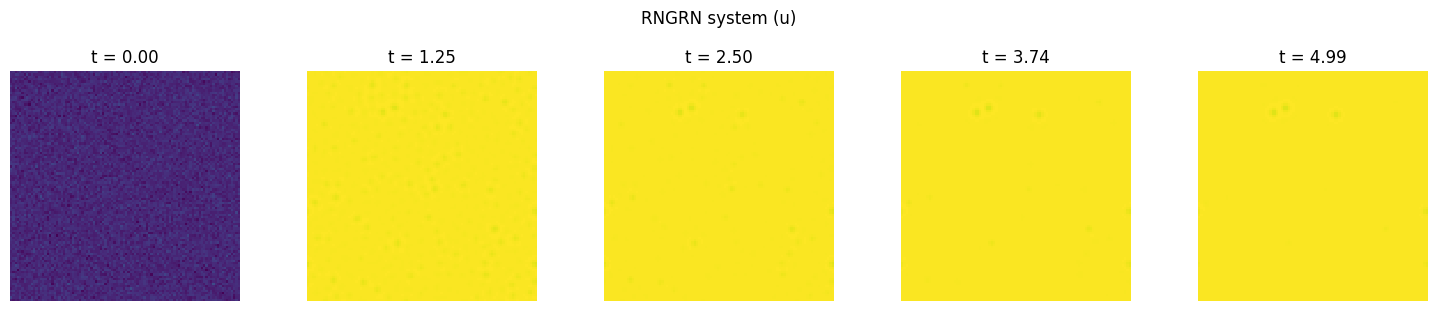

In [33]:
###Generate sample of simulation
#Sample frames 
num_snaps = len(trajectory_rngrn)
fractions = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
idxs = np.clip(np.round(fractions * (num_snaps - 1)).astype(int), 0, num_snaps - 1)

#Time per saved snap
dt_float = float(dt.item()) if hasattr(dt, "item") else float(dt)
times = idxs * dt_float

#Extract u frames 
u_frames = [trajectory_rngrn[i][:n_cells*n_cells].view(n_cells, n_cells).cpu().numpy() for i in idxs]

#Consistent colour scale 
vmin = min(frame.min() for frame in u_frames)
vmax = max(frame.max() for frame in u_frames)

#Plot u snapshots
fig, axes = plt.subplots(1, len(u_frames), figsize=(3*len(u_frames), 3))
for ax, fr, t in zip(axes, u_frames, times):
    ax.imshow(fr, origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f"t = {t:.2f}")
    ax.axis('off')
fig.suptitle('RNGRN system (u)', y=1.02)
plt.tight_layout()
plt.show()


## Simulate target system

In [ ]:
###Simulation with target system
trajectory_target = bdf1_newton_krylov(X0, dt, Tmax, rhs_target, jvp_func=None, tol=1e-2, max_iter=5, gmres_max_iter=200, save_interval=100)




In [ ]:
###Generate sample of simulation
#Sample frames 
num_snaps = len(trajectory_target)
fractions = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
idxs = np.clip(np.round(fractions * (num_snaps - 1)).astype(int), 0, num_snaps - 1)

#Time per saved snap
dt_float = float(dt.item()) if hasattr(dt, "item") else float(dt)
times = idxs * dt_float

#Extract u frames 
u_frames = [trajectory_target[i][:n_cells*n_cells].view(n_cells, n_cells).cpu().numpy() for i in idxs]

#Consistent colour scale 
vmin = min(frame.min() for frame in u_frames)
vmax = max(frame.max() for frame in u_frames)

#Plot u snapshots
fig, axes = plt.subplots(1, len(u_frames), figsize=(3*len(u_frames), 3))
for ax, fr, t in zip(axes, u_frames, times):
    ax.imshow(fr, origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f"t = {t:.2f}")
    ax.axis('off')
fig.suptitle('Target system (A)', y=1.02)
plt.tight_layout()
plt.show()


## Compare simulations

In [ ]:
###Calculate MSE over time
T = min(len(trajectory_target), len(trajectory_rngrn))

n_nodes = n_cells * n_cells
mse_u_x1 = []

for i in range(T):
    u_t = trajectory_target[i][:n_nodes].cpu().float()         
    x_block = trajectory_rngrn[i][:N * n_nodes].cpu().float()  
    x1 = x_block[:n_nodes]                                     
    mse_u_x1.append(float(((u_t - x1) ** 2).mean().item()))

mse_u_x1 = np.array(mse_u_x1)
overall_mse = mse_u_x1.mean()
print(f"Overall MSE between target A and RNGRN x1 over {T} timepoints: {overall_mse:.6e}")

dt_float = float(dt.item()) if hasattr(dt, "item") else float(dt)
times = np.arange(T) * dt_float

plt.figure(figsize=(8,4))
plt.semilogy(times, mse_u_x1, label="MSE(A vs x1)")
plt.xlabel("time")
plt.ylabel("MSE (log scale)")
plt.title("MSE between target A and RNGRN x1 over time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()